In [ ]:
%%capture
!pip install nlpaug
!pip install -U imbalanced-learn
!pip install scikit-learn --upgrade
!pip install pandas==1.1.5

## Dataset

In [ ]:
import urllib.request as req
from urllib.parse import urlparse
import os
import progressbar
import zipfile
import gzip
import shutil
import json
import pandas as pd
import re
import string
import imblearn

pbar = None


def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def wget(url):
    a = urlparse(url)
    filename = os.path.basename(a.path)
    if not os.path.isfile(filename):
        req.urlretrieve(url, filename, show_progress)
        print(f'downloaded to {filename}')
    else:
        print(f'file {filename} has already been downloaded')
    return filename

def unzip(filename, directory_to_extract_to=os.getcwd()):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
        print(f'extraction done {zip_ref.namelist()}')

def gunzip(gzfile, fout):
    with gzip.open(gzfile, 'rb') as f_in:
        with open(fout, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f'{gzfile} extracted to {fout}')


# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(df):
    """
    Preprocess the text for better understanding
    
    """
    # trim the whitespace at the edges of the string
    df['reviewText'] = df['reviewText'].str.strip()

    # lowercase the text in the string
    df['reviewText'] = df['reviewText'].str.lower()

    # replace new line with a .

    df['reviewText'] = df['reviewText'].replace('\n', ' . ')

    return df


# filename = wget("https://nlp.stanford.edu/data/glove.6B.zip")
# unzip(filename)
Video_Games_5 = wget('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz')
df = pd.read_json("./Video_Games_5.json.gz", lines=True, compression='gzip')
df = df.sample(50, random_state=42)
df = df[['reviewText', 'overall']]
df = text_preprocessing(df)
df = df.dropna()
df = df.drop_duplicates()
print(df.shape)

file Video_Games_5.json.gz has already been downloaded
(49, 2)


In [ ]:
df = df.reset_index(drop=True)
df

,reviewText,overall
0,love this 3ds game. i made a zombie togepi wit...,5
1,fun game,5
2,this game is so fun. i think it is the best s...,5
3,i hated the first game but absolutely love thi...,5
4,love the tales games. glad i purchased this one.,5
5,"great product, thank you",5
6,true to it's developer's (blizzard) reputation...,5
7,excelent,5
8,light and dark play a key role in remedy's lon...,4
9,much better environments this time around! the...,5


## Load USE

In [ ]:
import tensorflow_hub as hub

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_embs(text):
    if isinstance(text, str):
        text = [text]
    return use(text)

df['embs'] = df['reviewText'].apply(get_embs)

## Outlier detection

based on distance from the mean of all the samples

In [ ]:
import numpy as np
from scipy.spatial import distance

def detect_outliers(df, label, limit=0.2):
    # get the text and corresponding embeddings
    df = df[df['overall']==label]
    sentences = df.reviewText.values

    limit = int(limit * len(sentences))
    
    embs = df.embs.values
    tensor = np.vstack(embs)

    # get the mean embedding.
    mean = np.mean(tensor, axis=0)

    # Calculate the distance of each instance from the mean
    dist = distance.cdist(tensor, mean.reshape(1, -1), metric='euclidean')
    dist = dist.flatten()

    # Rank by distance in ascending order
    dist_with_index = list(zip(sentences, dist))
    dist_with_index.sort(reverse=True, key=lambda x: x[1])
    
    # Cut off the list, keeping only the top k% as outliers.
    i = 0
    while i < limit:
        sent = dist_with_index[i][0]
        print(sent)
        print('#'*10)
        i += 1

detect_outliers(df, 5)

bought for christmas present.
##########
my children love this.
##########
everything is great thanks
##########
perfect
##########
bought it a long time ago and is still around in great shape.
##########
i thought my last headset was good (rage tactical), but this blows it out of the water. has the leather feel that i like, fits comfortably around my ears and breathes so i don't have to keep removing them to exhaust heat. mic makes me sound like i have a lisp on s's but not too bad. audio is clear and has some bass to it if your audio card supports it. i'm happy with it.
##########
excellent
##########


## Data Augmentation

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
df['overall'].value_counts()

5    35
4     8
1     3
3     2
2     1
Name: overall, dtype: int64

In [ ]:
df.loc[39, 'reviewText']

"gameplay was fun but the live cut scenes were very long and drawn out. i'd find myself zoning out and then not even know what the heck was going on. if i wanted to watch a tv show i would've just logged into netflix. this is not a revolutionary game experience, it's just a game with a boring tv show hidden inside."

In [ ]:
for _, row in df[df.overall==3].iterrows():
    print(row['reviewText'])
    print("#"*10)

a word of warning: if you want to play titles for the original xbox such as halo 2, your system must have an official xbox-branded hard drive. that's why their drive costs more, it contains a partition that allows the old games to be played. i found this out the hard way, and now i'm trying to find a solution that involved needing to get the transfer cable and hook the hdd up to my computer, partition it, put some software mods onto it so that it will be backwards compatible, blah blah blah.

if you don't want to play old games, it's great. fits right into the slim and works very nicely.

update: if you get the proper transfer cable and download some software to your computer, you can hook this up to your computer and modify the drive by adding the partition to play original xbox discs. i successfully got my system to play halo 2, but it was kind of a pain and i had to go buy the usb-to-sata cable. so if you like to "hack" stuff, save a few bucks and mod the drive yourself, there are y

In [ ]:
df = df[df['overall']!=2]
print(df.shape)

(48, 3)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
type_one_hot = encoder.fit_transform(df.overall.to_numpy().reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(
    df, type_one_hot, stratify=df['overall'], test_size=.2, random_state=42)
emb_train = np.vstack(df_train.embs)
emb_test = np.vstack(df_test.embs)
print(df_train.shape, df_test.shape, y_train.shape, y_test.shape, emb_train.shape, emb_test.shape)

(38, 3) (10, 3) (38, 4) (10, 4) (38, 512) (10, 512)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
df_train_resampled, y_resampled = RandomOverSampler().fit_resample(df_train[['reviewText', 'overall']], y_train)
df_train_resampled = pd.DataFrame(df_train_resampled, columns=['reviewText', 'overall'])
df_train_resampled['overall'].value_counts()

5    28
4    28
3    28
1    28
Name: overall, dtype: int64

In [ ]:
df_train_resampled[df_train_resampled.overall==1].head()

,reviewText,overall
0,"kids don't like at all, told it's too boring a...",1
29,so i mark warcraft iii as the point where the ...,1
38,"kids don't like at all, told it's too boring a...",1
39,"kids don't like at all, told it's too boring a...",1
40,so i mark warcraft iii as the point where the ...,1


In [ ]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np

import tensorflow_hub as hub

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_embs(text):
    if isinstance(text, str):
        text = [text]
    return use(text)

X_train = []
for r in tqdm(df_train_resampled.reviewText):
    emb = get_embs(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)
X_train = np.array(X_train)

X_test = []
for r in tqdm(df_test.reviewText):
    emb = get_embs(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)
X_test = np.array(X_test)

100%|██████████| 10/10 [00:00<00:00, 176.71it/s]


### Model without augmentation

Since the data is very less, there is no point in splitting in train and validation

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(X_train, y_train, epochs=10):
    model = Sequential()
    model.add(Dense(units=256,input_shape=(X_train.shape[1],),activation='relu'))
    # model.add(Dropout(rate=0.5))
    model.add(Dense(units=128,activation='relu'))
    # model.add(Dropout(rate=0.5))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=16,
        verbose=1,
        shuffle=True
    )

    return history, model


history, random_aug_model = build_model(X_train, y_resampled, 3)

Epoch 1/3
7/7 [==============================] - 0s 5ms/step - loss: 1.2860 - accuracy: 0.5804
Epoch 2/3
7/7 [==============================] - 0s 5ms/step - loss: 0.9962 - accuracy: 0.9375
Epoch 3/3
7/7 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.9643


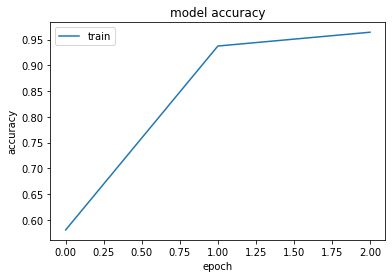

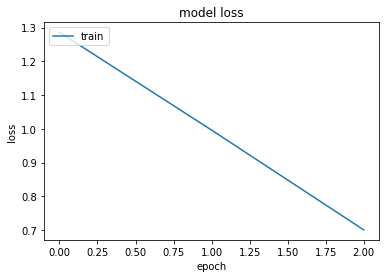

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    ## summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ## summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

plot_history(history)

In [ ]:
loss, acc = random_aug_model.evaluate(X_test, y_test)
print('loss:', loss, 'accuracy:', acc)

1/1 [==============================] - 0s 151ms/step - loss: 1.1153 - accuracy: 0.7000
loss: 1.1152918338775635 accuracy: 0.699999988079071


In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

y_pred = np.argmax(random_aug_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print('accuracy:', accuracy_score(y_true, y_pred))
print('matthews_corrcoef:', matthews_corrcoef(y_true, y_pred))
print('classification_report:\n', classification_report_imbalanced(y_true, y_pred))

accuracy: 0.7
matthews_corrcoef: 0.0
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00         1
          2       0.00      0.00      1.00      0.00      0.00      0.00         2
          3       0.70      1.00      0.00      0.82      0.00      0.00         7

avg / total       0.49      0.70      0.30      0.58      0.00      0.00        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model performance after augmentation

check the label distribution before augmenting. label 5 is the largest label

In [ ]:
df_train.overall.value_counts()

5    28
4     6
3     2
1     2
Name: overall, dtype: int64

code for nlp augmentation

In [ ]:
from random import choice, random

def remove_random_space(text):
    indices = [i for i, x in enumerate(text) if x == " "]
    random_space_index = choice(indices)
    return "".join([x for i, x in enumerate(text) if i!=random_space_index])

def delete_char_randomly(text):
    random_char_indx = int(random() * len(text))
    # print(random_char_indx)
    return "".join([x for i, x in enumerate(text) if i!=random_char_indx])

def keyboard_augmenter(text):
    aug = nac.KeyboardAug()
    augmented_text = aug.augment(text)
    return augmented_text

def augment_label(df_train, label, n_out):
    sentences = df_train[df_train.overall==label].reviewText.to_list()

    aug_sentences = []
    factor = round(n_out/(4*len(sentences)))
    sentences = sentences * factor
    for sent in sentences:
        aug_sentences.append(sent)
        aug_sentences.append(remove_random_space(sent))
        aug_sentences.append(keyboard_augmenter(sent))
        aug_sentences.append(delete_char_randomly(sent))

    aug_df = pd.DataFrame(aug_sentences, columns=['reviewText'])
    aug_df['overall'] = label

    return aug_df


# get the augmented values
df_train2 = df_train[df_train.overall==5]
print(df_train2.shape)
aug_df4 = augment_label(df_train, 4, 28)
aug_df3 = augment_label(df_train, 3, 28)
aug_df1 = augment_label(df_train, 1, 28)
df_train2 = pd.concat([df_train2, aug_df4, aug_df3, aug_df1], ignore_index=True)

# shuffle the dataframe so that same labels are not together
df_train2 = df_train2.sample(frac=1, random_state=42)
print(df_train2.shape)
print(df_train2.overall.value_counts())

(28, 3)
(116, 3)
3    32
1    32
5    28
4    24
Name: overall, dtype: int64


recompute the X_train and y_train as the training distributions are now different.

In [ ]:
y_train = encoder.transform(df_train2.overall.to_numpy().reshape(-1, 1))

X_train = []
for r in tqdm(df_train2.reviewText):
    emb = get_embs(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)
X_train = np.array(X_train)
print(X_train.shape)

100%|██████████| 116/116 [00:00<00:00, 153.14it/s]

(116, 512)


train the model using 3 epochs

Epoch 1/3
8/8 [==============================] - 0s 4ms/step - loss: 1.3096 - accuracy: 0.6034
Epoch 2/3
8/8 [==============================] - 0s 4ms/step - loss: 1.0525 - accuracy: 0.9397
Epoch 3/3
8/8 [==============================] - 0s 4ms/step - loss: 0.7263 - accuracy: 0.9828


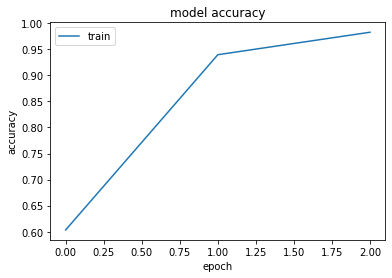

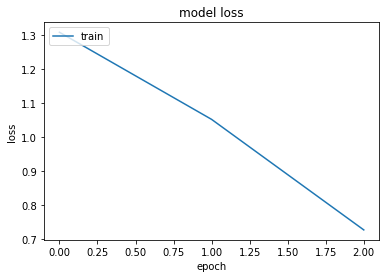

In [ ]:
history, nlp_aug_model = build_model(X_train, y_train, 3)
plot_history(history)

In [ ]:
loss, acc = nlp_aug_model.evaluate(X_test, y_test)
print('loss:', loss, 'accuracy:', acc)

1/1 [==============================] - 0s 146ms/step - loss: 1.0927 - accuracy: 0.8000
loss: 1.0927302837371826 accuracy: 0.800000011920929


the simple augmentation model has mostly overfitted, but there is some other values as part of the nlp augmented model.

In [ ]:
print('simple oversampling outputs:', np.argmax(random_aug_model.predict(X_test), axis=1))
print('nlp model outputs:', np.argmax(nlp_aug_model.predict(X_test), axis=1))
print('actual outputs:', np.argmax(y_test, axis=1))

simple oversampling outputs: [3 3 3 3 3 3 3 3 3 3]
nlp model outputs: [2 3 3 3 3 3 3 3 3 3]
actual outputs: [2 3 3 2 0 3 3 3 3 3]


In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

y_pred = np.argmax(nlp_aug_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print('accuracy:', accuracy_score(y_true, y_pred))
print('matthews_corrcoef:', matthews_corrcoef(y_true, y_pred))
print('classification_report:\n', classification_report_imbalanced(y_true, y_pred))

accuracy: 0.8
matthews_corrcoef: 0.5212860351426869
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00         1
          2       1.00      0.50      1.00      0.67      0.71      0.48         2
          3       0.78      1.00      0.33      0.88      0.58      0.36         7

avg / total       0.74      0.80      0.53      0.75      0.55      0.34        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
